In [1]:
import time
import spo
import torch
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
torch.manual_seed(135)

## Init Data 

In [2]:
# generate data for grid network (features and costs)
grid = (5,5) # grid graph
n = 1000 # number of data
p = 5 # size of feature
deg = 4 # polynomial degree
x, c = spo.data.shortestpath.genData(n+1000, p, grid, deg=deg)

## Optimization Model 

In [3]:
# model for shortest path
sp_model = spo.model.omo.shortestPathModel(grid, solver='gurobi')
#sp_model = spo.model.omo.shortestPathModel(grid, solver='glpk')

In [4]:
# solve
sp_model.setObj([1 for i in range(40)])
sol, obj = sp_model.solve()
print('Obj: {}'.format(obj))
for i, e in enumerate(sp_model.arcs):
    if sol[i] > 1e-3:
        print(e)

Academic license - for non-commercial use only - expires 2021-10-08
Using license file C:\Users\Apocrypse\gurobi.lic
Obj: 8.0
(0, 1)
(1, 2)
(2, 7)
(7, 12)
(12, 17)
(17, 18)
(18, 19)
(19, 24)


## Data Loader

In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [6]:
# data split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)

In [7]:
# get training data set
sp_dataset_train = spo.data.dataset.optDataset(sp_model, x_train, c_train)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 98.90it/s]


In [8]:
# get test data set
sp_dataset_test = spo.data.dataset.optDataset(sp_model, x_test, c_test)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.13it/s]


In [9]:
# get data loader
batch_size = 32
sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)

In [10]:
for i, data in enumerate(sp_loader_train):
    x, c, w, z = data
    break

In [11]:
x.shape

torch.Size([32, 5])

In [12]:
c.shape

torch.Size([32, 40])

In [13]:
w.shape

torch.Size([32, 40])

In [14]:
z.shape

torch.Size([32, 1])

## Linear Regression from Scikit-Learn 

In [15]:
from sklearn.linear_model import LinearRegression

In [16]:
# prediction model
reg = LinearRegression()

## Two-Stage

In [17]:
# build model
twostage_model = spo.twostage.sklearnPred(reg, sp_model)

In [18]:
# training
twostage_model.fit(sp_dataset_train.x, sp_dataset_train.c)

In [19]:
# prediction
c_test_pred = twostage_model.predict(sp_dataset_test.x)

In [20]:
# evaluate
truespo = 0
unambspo = 0
for i in tqdm(range(1000)):
    c_pred_i = c_test_pred[i]
    c_true_i = sp_dataset_test.c[i]
    z_true_i = sp_dataset_test.z[i,0]
    truespo += spo.eval.calTrueSPO(sp_model, c_pred_i, c_true_i, z_true_i)
    unambspo += spo.eval.calUnambSPO(sp_model, c_pred_i, c_true_i, z_true_i)
time.sleep(1)
print('Normalized true SPO Loss: {:.2f}%'.format(truespo / abs(sp_dataset_test.z.sum()) * 100))
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(unambspo / abs(sp_dataset_test.z.sum()) * 100))

100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:45<00:00, 21.91it/s]


Normalized true SPO Loss: 1.61%
Normalized unambiguous SPO Loss: 1.61%


In [21]:
# compare solutions
for i, data in enumerate(sp_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    # predict
    cp = twostage_model.predict(x)
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 35.78, 26.44, 82.00, 4.47, 120.99, 13.57, 9.10, 32.00, 14.31, 50.36, 13.57, 25.84, 5.78, 32.00, 10.80, 32.00, 2.86, 37.30, 22.91, 13.57, 25.84, 37.30, 59.39, 21.15, 105.33, 9.10, 10.80, 10.80, 54.85, 61.69, 44.51, 5.78, 44.51, 26.44, 82.00, 61.69, 9.10, 61.69, 18.65, 37.30
    Pred cost: 41.72, 23.47, 82.00, -99.87, 148.14, -31.22, -61.21, 44.60, -28.40, 62.24, -31.22, 6.24, -85.57, 44.60, -49.48, 44.60, -126.51, 30.47, 7.96, -31.22, 6.24, 30.47, 85.69, -13.09, 118.08, -61.21, -49.48, -49.48, 68.32, 82.62, 49.32, -85.57, 49.32, 23.47, 82.00, 82.62, -61.21, 82.62, -7.76, 30.47
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 201.43
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, Pred obj: 220.04

Sample 1:
    True cost: 1.41, 99.22, 82.00, 19.81, 13.06, 2.75, 12.75, 55.24, 9.98, 50.2

## Linear Regression from PyTorch

In [22]:
from torch import nn

In [23]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, (grid[0] - 1) * grid[1] + (grid[1] - 1) * grid[0])
    
    def forward(self, x):
        out = self.linear(x)
        return out

## SPO+

In [24]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [25]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=5e-2)

In [26]:
# init SPO+ loss
criterion = spo.func.SPOPlus(sp_model, processes=4)

Num of cores: 4


In [27]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, sp_model, sp_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, sp_model, sp_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss: 399.4269, True SPO Loss:  2.5966%, Unambiguous SPO Loss:  2.5966%
Epoch  20, Loss: 239.7885, True SPO Loss:  1.3939%, Unambiguous SPO Loss:  1.3939%
Epoch  30, Loss: 118.0380, True SPO Loss:  1.1568%, Unambiguous SPO Loss:  1.1568%
Epoch  40, Loss:  62.4741, True SPO Loss:  1.0121%, Unambiguous SPO Loss:  1.0121%
Epoch  50, Loss: 261.4393, True SPO Loss:  0.8631%, Unambiguous SPO Loss:  0.8631%
Epoch  60, Loss: 139.2957, True SPO Loss:  0.7327%, Unambiguous SPO Loss:  0.7327%
Epoch  70, Loss:  47.1679, True SPO Loss:  0.6664%, Unambiguous SPO Loss:  0.6664%
Epoch  80, Loss:  15.3169, True SPO Loss:  0.5956%, Unambiguous SPO Loss:  0.5956%
Epoch  90, Loss:  81.4306, True SPO Loss:  0.5169%, Unambiguous SPO Loss:  0.5169%
Epoch 100, Loss:   1.6431, True SPO Loss:  0.5549%, Unambiguous SPO Loss:  0.5549%
Epoch 110, Loss:   7.7799, True SPO Loss:  0.5355%, Unambiguous SPO Loss:  0.5355%
Epoch 120, Loss:   3.2690, True SPO Loss:  0.5312%, Unambiguous SPO Loss:  0.5312%
Epoc

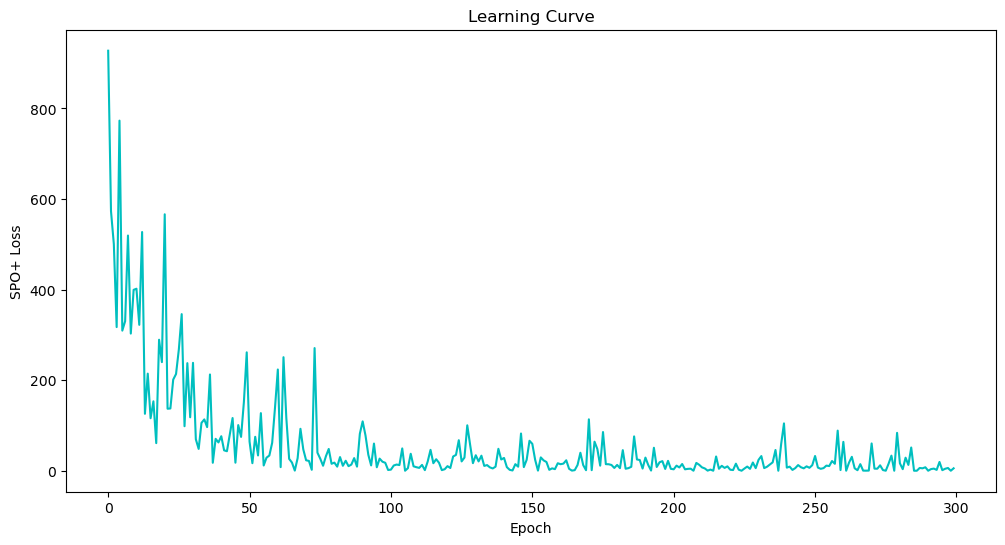

In [28]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

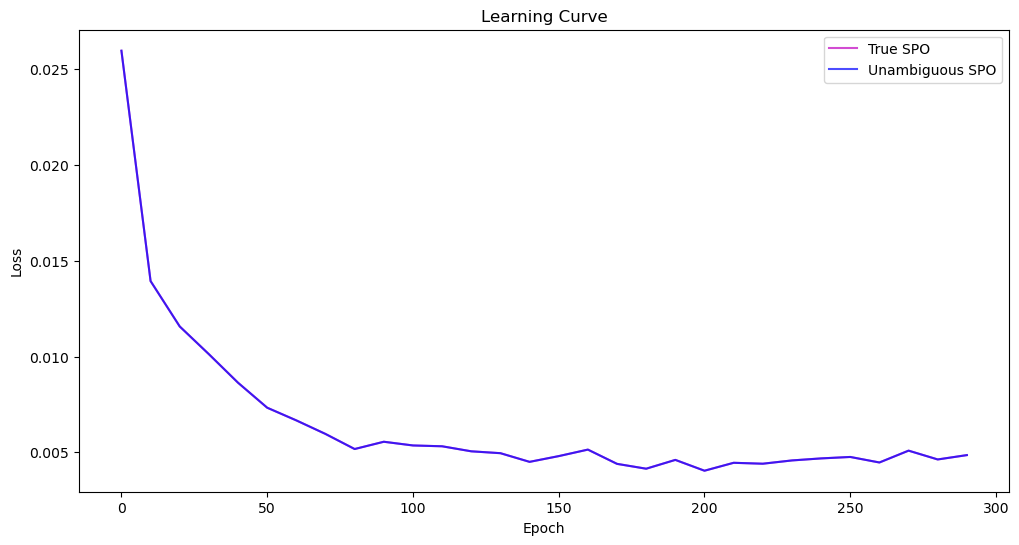

In [29]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [30]:
# evaluate
spoloss = spo.eval.trueSPO(reg, sp_model, sp_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, sp_model, sp_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 0.49%
Normalized unambiguous SPO Loss: 0.49%


In [31]:
# compare solutions
reg.eval()
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 35.78, 26.44, 82.00, 4.47, 120.99, 13.57, 9.10, 32.00, 14.31, 50.36, 13.57, 25.84, 5.78, 32.00, 10.80, 32.00, 2.86, 37.30, 22.91, 13.57, 25.84, 37.30, 59.39, 21.15, 105.33, 9.10, 10.80, 10.80, 54.85, 61.69, 44.51, 5.78, 44.51, 26.44, 82.00, 61.69, 9.10, 61.69, 18.65, 37.30
    Pred cost: -84.36, -1.17, 10.77, 1.13, 85.85, -83.58, -15.97, 23.17, 3.15, 67.61, -15.86, -94.06, -29.92, 39.24, -23.89, 73.17, -83.96, -19.59, 44.27, -28.24, -29.78, -17.08, -0.68, 43.50, 50.35, -66.64, -26.69, 7.00, 37.73, 119.59, 16.90, -15.98, 15.37, -36.19, 30.37, -2.24, -18.12, 0.62, -36.07, 3.50
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 201.43
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, Pred obj: 206.94

Sample 1:
    True cost: 1.41, 99.22, 82.00, 19.81, 13.06, 2.75, 12.75, 55.24, 9.98, 50.27

##  SPO+ with Regularization

In [32]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [33]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=5e-2)

In [34]:
# init SPO+ loss
criterion = spo.func.SPOPlus(sp_model, processes=4)

Num of cores: 4


In [35]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(cp, c, w, z).mean()
        # l1 reg
        l1_lambda = 1e-3
        l1_reg = torch.abs(cp - c).sum(dim=1).mean()
        loss += l1_lambda * l1_reg
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, sp_model, sp_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, sp_model, sp_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss: 429.1037, True SPO Loss:  3.6794%, Unambiguous SPO Loss:  3.6794%
Epoch  20, Loss: 120.3953, True SPO Loss:  1.3664%, Unambiguous SPO Loss:  1.3664%
Epoch  30, Loss: 201.5956, True SPO Loss:  1.0926%, Unambiguous SPO Loss:  1.0926%
Epoch  40, Loss:  21.6961, True SPO Loss:  0.9196%, Unambiguous SPO Loss:  0.9196%
Epoch  50, Loss:  11.1293, True SPO Loss:  0.8355%, Unambiguous SPO Loss:  0.8355%
Epoch  60, Loss:  50.7304, True SPO Loss:  0.7110%, Unambiguous SPO Loss:  0.7110%
Epoch  70, Loss: 120.8037, True SPO Loss:  0.6501%, Unambiguous SPO Loss:  0.6501%
Epoch  80, Loss:  18.5684, True SPO Loss:  0.6274%, Unambiguous SPO Loss:  0.6274%
Epoch  90, Loss:   9.8583, True SPO Loss:  0.5843%, Unambiguous SPO Loss:  0.5843%
Epoch 100, Loss:  33.1067, True SPO Loss:  0.5444%, Unambiguous SPO Loss:  0.5444%
Epoch 110, Loss:   8.4227, True SPO Loss:  0.5327%, Unambiguous SPO Loss:  0.5327%
Epoch 120, Loss:  13.9358, True SPO Loss:  0.5007%, Unambiguous SPO Loss:  0.5007%
Epoc

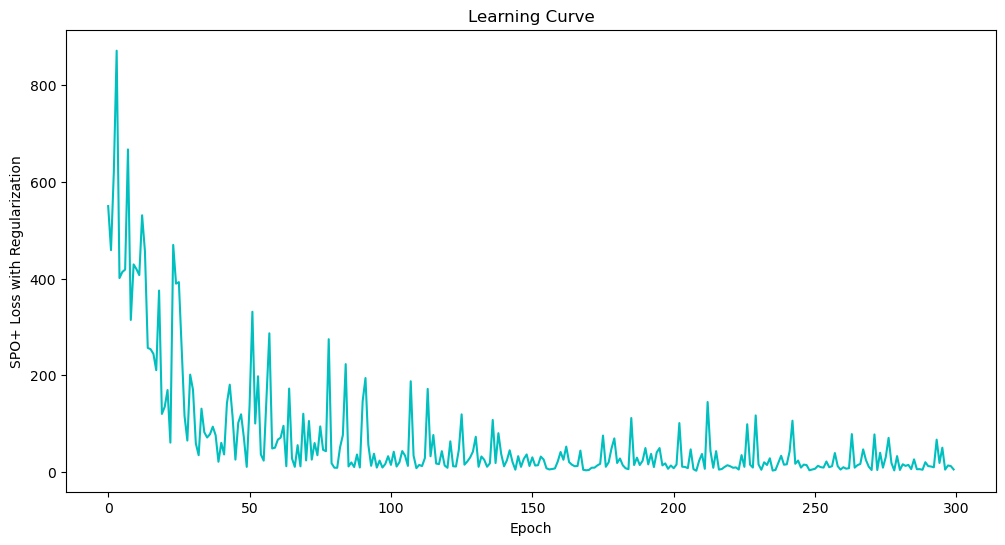

In [36]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss with Regularization')
plt.title('Learning Curve')
plt.show()

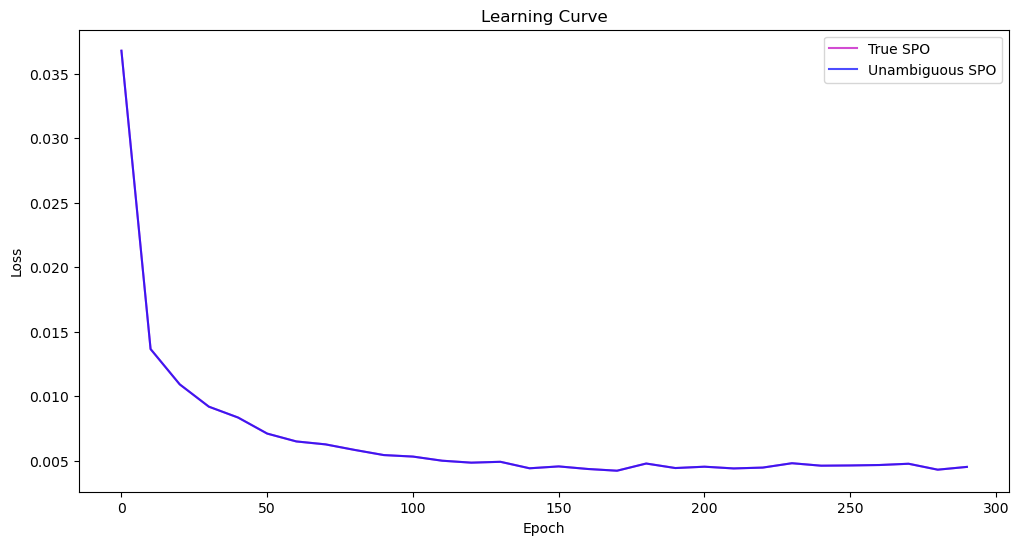

In [37]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [38]:
# evaluate
spoloss = spo.eval.trueSPO(reg, sp_model, sp_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, sp_model, sp_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 0.45%
Normalized unambiguous SPO Loss: 0.45%


In [39]:
# compare solutions
reg.eval()
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 35.78, 26.44, 82.00, 4.47, 120.99, 13.57, 9.10, 32.00, 14.31, 50.36, 13.57, 25.84, 5.78, 32.00, 10.80, 32.00, 2.86, 37.30, 22.91, 13.57, 25.84, 37.30, 59.39, 21.15, 105.33, 9.10, 10.80, 10.80, 54.85, 61.69, 44.51, 5.78, 44.51, 26.44, 82.00, 61.69, 9.10, 61.69, 18.65, 37.30
    Pred cost: -81.05, -7.73, 12.62, 1.21, 81.59, -83.48, -18.75, -8.66, 3.60, 74.94, -13.78, -86.70, -32.93, 26.50, -18.35, 65.12, -81.81, -12.10, 29.05, -26.90, -31.86, -16.70, 4.83, 39.66, 45.74, -71.50, -21.99, 8.92, 39.80, 109.16, 19.72, -14.41, 18.28, -38.45, 30.60, 1.40, -14.81, 9.78, -36.10, 4.16
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 201.43
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, Pred obj: 206.94

Sample 1:
    True cost: 1.41, 99.22, 82.00, 19.81, 13.06, 2.75, 12.75, 55.24, 9.98, 50.27, 

    True sol: 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 506.57
    Pred sol: 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, Pred obj: 506.57



## Black-Box

In [40]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [41]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-4)

In [42]:
# set loss
criterion = nn.L1Loss()
bb = spo.func.blackboxOpt(sp_model, lambd=10, processes=4)

Num of cores: 4


In [43]:
# train model
num_epochs = 300
lambd = 10
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # linear regression
        cp = reg(x)
        # black-box optimizer
        wp = bb.apply(cp)
        # objective value
        zp = (wp * c).sum(1).view(-1, 1)
        # loss
        loss = criterion(zp, z)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, sp_model, sp_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, sp_model, sp_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss: 403.9380, True SPO Loss: 61.9874%, Unambiguous SPO Loss: 61.9874%
Epoch  20, Loss: 219.8508, True SPO Loss: 57.4095%, Unambiguous SPO Loss: 57.4095%
Epoch  30, Loss: 258.0971, True SPO Loss: 51.4813%, Unambiguous SPO Loss: 51.4813%
Epoch  40, Loss: 314.5955, True SPO Loss: 44.5109%, Unambiguous SPO Loss: 44.5109%
Epoch  50, Loss: 191.3732, True SPO Loss: 36.9171%, Unambiguous SPO Loss: 36.9171%
Epoch  60, Loss: 457.2165, True SPO Loss: 29.2923%, Unambiguous SPO Loss: 29.2923%
Epoch  70, Loss: 105.6105, True SPO Loss: 22.3197%, Unambiguous SPO Loss: 22.3197%
Epoch  80, Loss: 223.7784, True SPO Loss: 17.7648%, Unambiguous SPO Loss: 17.7648%
Epoch  90, Loss: 128.1826, True SPO Loss: 14.2258%, Unambiguous SPO Loss: 14.2258%
Epoch 100, Loss: 103.3355, True SPO Loss: 11.1293%, Unambiguous SPO Loss: 11.1293%
Epoch 110, Loss:  90.6049, True SPO Loss:  8.6451%, Unambiguous SPO Loss:  8.6451%
Epoch 120, Loss:  19.3376, True SPO Loss:  6.3690%, Unambiguous SPO Loss:  6.3690%
Epoc

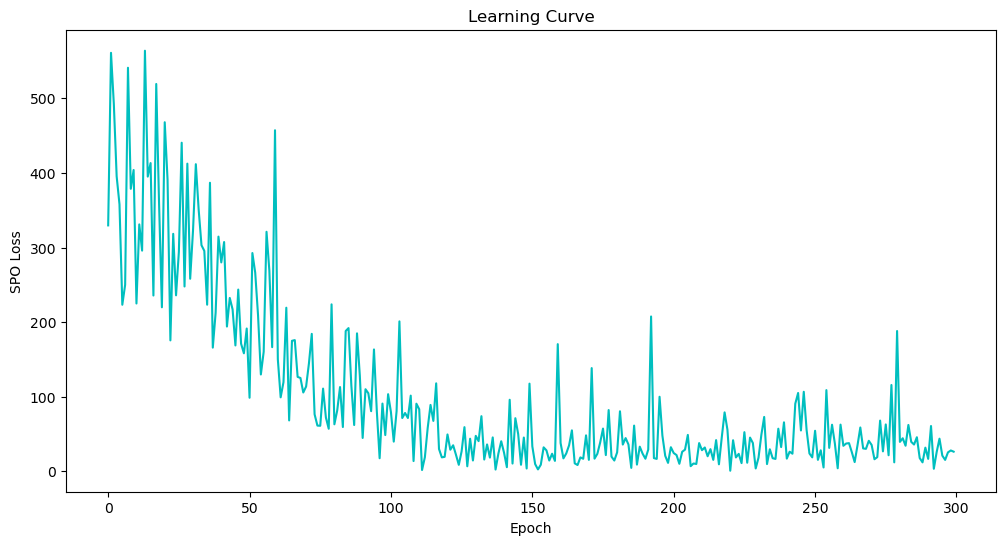

In [44]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO Loss')
plt.title('Learning Curve')
plt.show()

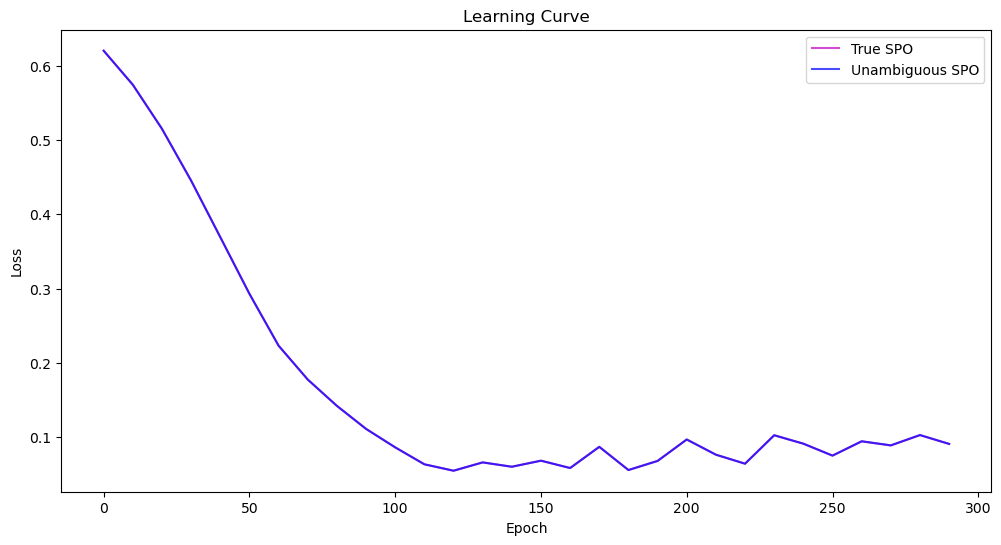

In [45]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [46]:
# evaluate
spoloss = spo.eval.trueSPO(reg, sp_model, sp_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, sp_model, sp_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 9.11%
Normalized unambiguous SPO Loss: 9.11%


In [47]:
# compare solutions
reg.eval()
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 35.78, 26.44, 82.00, 4.47, 120.99, 13.57, 9.10, 32.00, 14.31, 50.36, 13.57, 25.84, 5.78, 32.00, 10.80, 32.00, 2.86, 37.30, 22.91, 13.57, 25.84, 37.30, 59.39, 21.15, 105.33, 9.10, 10.80, 10.80, 54.85, 61.69, 44.51, 5.78, 44.51, 26.44, 82.00, 61.69, 9.10, 61.69, 18.65, 37.30
    Pred cost: 1.00, -0.03, 0.17, -1.61, 0.18, -0.36, -1.34, -0.11, -1.37, 0.46, -1.02, 0.22, -1.05, -0.82, -1.10, 0.37, 0.16, 1.14, 0.18, 0.46, 0.01, -0.69, 0.33, 0.86, 0.45, -0.91, 0.32, 0.71, 0.05, -1.34, 0.53, 0.80, -0.74, -0.28, 1.30, 0.14, -0.57, 0.51, 0.23, -0.63
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 201.43
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, Pred obj: 206.94

Sample 1:
    True cost: 1.41, 99.22, 82.00, 19.81, 13.06, 2.75, 12.75, 55.24, 9.98, 50.27, 2.75, 6.06, 8.38, 55.24, 7.29, 55.2

## Black-Box with Regularization

In [48]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [49]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-4)

In [50]:
# set loss
bb = spo.func.blackboxOpt(sp_model, lambd=10, processes=4)
criterion = nn.L1Loss()

Num of cores: 4


In [51]:
# train model
num_epochs = 300
lambd = 10
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # linear regression
        cp = reg(x)
        # black-box optimizer
        wp = bb.apply(cp)
        # objective value
        zp = (wp * c).sum(1).view(-1, 1)
        # loss
        loss = criterion(zp, z)
        # l1 reg
        l1_lambda = 1e-3
        l1_reg = torch.abs(cp - c).sum(dim=1).mean()
        loss += l1_lambda * l1_reg
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, sp_model, sp_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, sp_model, sp_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss: 377.9807, True SPO Loss: 44.4319%, Unambiguous SPO Loss: 44.4319%
Epoch  20, Loss: 391.6345, True SPO Loss: 36.4064%, Unambiguous SPO Loss: 36.4064%
Epoch  30, Loss: 145.0512, True SPO Loss: 31.4519%, Unambiguous SPO Loss: 31.4519%
Epoch  40, Loss: 139.7082, True SPO Loss: 27.2544%, Unambiguous SPO Loss: 27.2544%
Epoch  50, Loss:  66.2770, True SPO Loss: 23.3320%, Unambiguous SPO Loss: 23.3320%
Epoch  60, Loss: 136.8759, True SPO Loss: 17.6300%, Unambiguous SPO Loss: 17.6300%
Epoch  70, Loss:  34.5663, True SPO Loss: 13.8671%, Unambiguous SPO Loss: 13.8671%
Epoch  80, Loss:  20.8569, True SPO Loss:  9.9306%, Unambiguous SPO Loss:  9.9306%
Epoch  90, Loss:  20.6679, True SPO Loss:  7.2557%, Unambiguous SPO Loss:  7.2557%
Epoch 100, Loss: 110.3962, True SPO Loss:  5.6510%, Unambiguous SPO Loss:  5.6510%
Epoch 110, Loss:  28.1666, True SPO Loss:  4.8390%, Unambiguous SPO Loss:  4.8390%
Epoch 120, Loss:  18.8130, True SPO Loss:  4.4216%, Unambiguous SPO Loss:  4.4216%
Epoc

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


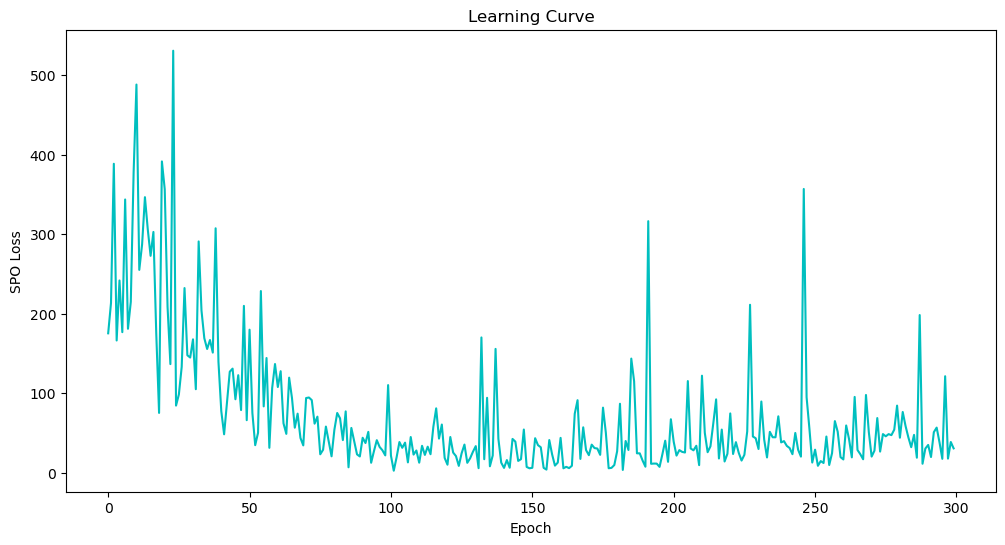

In [52]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO Loss')
plt.title('Learning Curve')
plt.show()

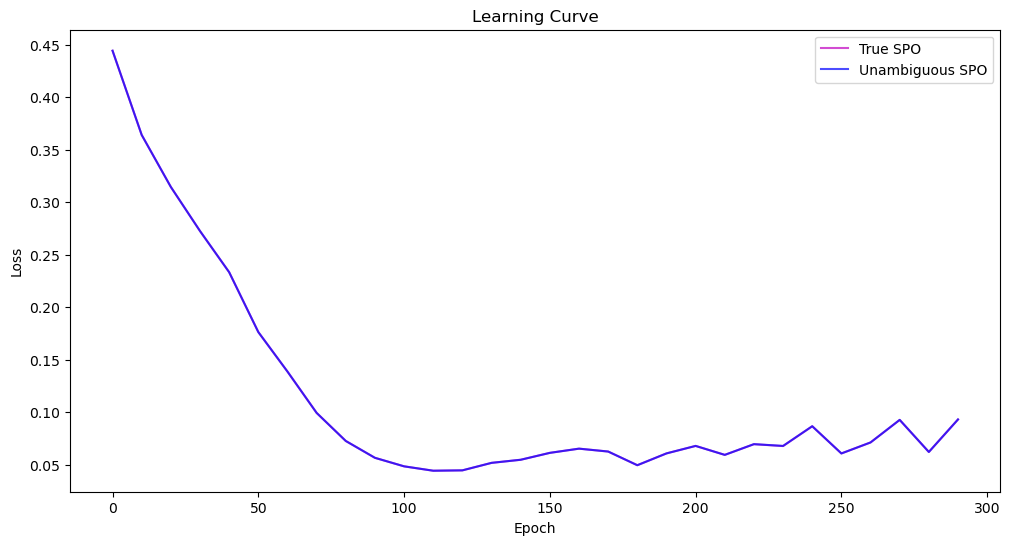

In [53]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [54]:
# evaluate
spoloss = spo.eval.trueSPO(reg, sp_model, sp_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, sp_model, sp_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 9.31%
Normalized unambiguous SPO Loss: 9.31%


In [55]:
# compare solutions
reg.eval()
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 35.78, 26.44, 82.00, 4.47, 120.99, 13.57, 9.10, 32.00, 14.31, 50.36, 13.57, 25.84, 5.78, 32.00, 10.80, 32.00, 2.86, 37.30, 22.91, 13.57, 25.84, 37.30, 59.39, 21.15, 105.33, 9.10, 10.80, 10.80, 54.85, 61.69, 44.51, 5.78, 44.51, 26.44, 82.00, 61.69, 9.10, 61.69, 18.65, 37.30
    Pred cost: -0.11, 0.89, -0.55, -1.59, -0.86, -0.43, -1.27, -0.48, 0.76, 0.33, 0.03, 0.01, 1.45, 0.62, 0.40, 0.59, -0.49, -0.46, 0.11, 0.22, -1.07, -0.07, 0.87, 0.59, 0.11, 0.95, 1.33, 0.05, -0.25, -0.24, 0.31, -0.89, 0.25, -0.19, -0.01, -1.37, 0.53, -0.26, -0.06, -1.04
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 201.43
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, Pred obj: 220.04

Sample 1:
    True cost: 1.41, 99.22, 82.00, 19.81, 13.06, 2.75, 12.75, 55.24, 9.98, 50.27, 2.75, 6.06, 8.38, 55.24, 7.29, 5